<a href="https://colab.research.google.com/github/AayanHidol/NNZH-by-Andrej-Karpathy/blob/main/Building_makemore_Part_4_becoming_a_backprop_ninja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt

--2025-07-17 12:47:19--  https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-17 12:47:19 (6.01 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:
batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3378, grad_fn=<NegBackward0>)

In [10]:
Yb

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [11]:
logprobs

tensor([[-2.6243, -2.4272, -3.9326, -3.0437, -3.9910, -2.5102, -3.6711, -3.3064,
         -4.0604, -3.3960, -3.2875, -3.2504, -3.2716, -3.6041, -3.4224, -4.3628,
         -4.7433, -3.8807, -4.1414, -2.8956, -2.9827, -3.7114, -3.6110, -2.7291,
         -2.8693, -3.5904, -3.8866],
        [-2.8143, -2.8773, -2.3844, -2.9521, -3.3732, -3.3491, -3.9144, -3.0519,
         -3.9707, -3.6425, -3.0702, -3.0263, -3.0289, -3.5845, -3.1193, -3.3982,
         -3.5679, -4.0590, -3.8763, -3.3197, -3.9154, -3.6202, -4.1529, -2.7958,
         -3.8006, -3.2692, -3.7805],
        [-3.8690, -3.7325, -4.1361, -4.3629, -3.8186, -3.1324, -2.7301, -2.7434,
         -2.8850, -3.4244, -3.8443, -3.3003, -3.1144, -3.0451, -3.8552, -3.6331,
         -4.2976, -3.3922, -3.5851, -2.2865, -2.7390, -3.2471, -3.1220, -3.2976,
         -3.3167, -3.8868, -3.6085],
        [-3.3875, -3.6447, -3.2172, -3.0124, -2.8729, -3.4839, -2.9755, -3.2208,
         -3.1067, -3.8101, -3.2562, -3.6288, -3.3350, -3.1685, -2.8321, -2.8606

In [12]:
logprobs[range(n), Yb]

tensor([-4.0604, -3.1193, -3.6331, -3.1463, -4.0702, -3.5471, -3.0181, -4.0127,
        -3.2689, -4.2172, -3.1240, -1.6917, -2.9079, -3.0031, -3.0500, -3.0799,
        -3.8255, -2.9947, -3.6936, -3.3302, -2.7834, -2.8472, -4.2172, -4.0096,
        -3.4515, -2.8693, -2.8672, -3.9514, -2.8617, -3.3062, -3.2067, -3.1283],
       grad_fn=<IndexBackward0>)

In [13]:
# loss = -1/3*a -1/3*b -1/3*c (for 3 characters)
# dloss/da = -1/3
# dloss/da = -1/n (more generally)

In [14]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [15]:
# c = a * b, but with tensors:
# a[3,3] * b[3,1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
# c[3,3]


In [16]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [17]:
# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)

In [18]:
norm_logits.shape, logits.shape, logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [19]:
# c11 c12 c13 = a11 a12 a13     b1
# c21 c22 c23 = a21 a22 a23  -  b2
# c31 c32 c33 = a31 a32 a33     b3

# so e.g. c32 = a32 - b3

In [20]:
#dlogit_maxes # the gradient of logit_maxes is intutively 0

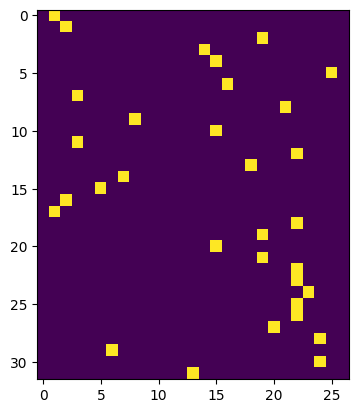

In [21]:
plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))

In [22]:
logits.max(1, keepdim=True)

torch.return_types.max(
values=tensor([[0.9918],
        [0.7969],
        [1.0879],
        [0.4565],
        [1.5636],
        [0.9086],
        [0.7110],
        [1.3253],
        [1.0712],
        [0.9779],
        [1.6448],
        [1.9672],
        [1.0797],
        [0.8068],
        [0.5617],
        [0.7482],
        [0.8727],
        [0.7880],
        [1.0797],
        [0.7865],
        [0.6464],
        [0.9341],
        [1.0797],
        [1.3094],
        [1.4491],
        [0.9006],
        [1.2623],
        [0.9493],
        [0.8552],
        [0.8359],
        [1.0787],
        [0.8091]], grad_fn=<MaxBackward0>),
indices=tensor([[ 1],
        [ 2],
        [19],
        [14],
        [15],
        [25],
        [16],
        [ 3],
        [21],
        [ 8],
        [15],
        [ 3],
        [22],
        [18],
        [ 7],
        [ 5],
        [ 2],
        [ 1],
        [22],
        [19],
        [15],
        [19],
        [22],
        [22],
        [23],
        [

In [25]:
dlogits.shape, h.shape, W2.shape, b2.shape

(torch.Size([32, 27]),
 torch.Size([32, 64]),
 torch.Size([64, 27]),
 torch.Size([27]))

In [26]:
# If we check out the shapes
# there is only one way that we can make dh = some combination of logits and W2
dh = dlogits @ W2.T
#32x64 = 32x27 @ (64x27).T
dW2 = h.T @ dlogits
#64x27 = (32x63).T @ 32x27
db2 = dlogits.sum(0)

In [32]:
hpreact.shape, bngain.shape, bnraw.shape, bnbias.shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]))

In [ ]:
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

In [34]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [36]:
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (dbndiff * dbnraw).sum(0, keepdim=True)


In [ ]:
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv

In [40]:
bnvar.shape, bndiff.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [ ]:
# a11 a12
# a21 a22
# --->
# b1  b2, where:
# b1 = 1/(n-1)*(a11 + a21)
# b2 = 1/(n-1)*(a12 + a22)

In [ ]:
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar

In [ ]:
dbndiff += (2 * bndiff) * dbndiff2

In [11]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [ ]:
dhprebn = dbndiff.clone()
#dbnmeani = (-torch.ones_like(bndiff) * dbndiff).sum(0)
dbnmeani = (-dbndiff).sum(0)

In [13]:
bndiff.shape, hprebn.shape, bnmeani.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [ ]:
dhprebn = 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

In [15]:
# forward pass: hprebn = embcat @ W1 + b1
hprebn.shape, embcat.shape, W1.shape, b1.shape

(torch.Size([32, 64]),
 torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]))

In [ ]:
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

In [16]:
# forward pass: embcat = emb.view(emb.shape[0], -1)
embcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [ ]:
demb = dembcat.view(emb.shape)

In [18]:
# forward pass: emb = C[Xb]
print(emb.shape, C.shape, Xb.shape)
print(Xb[:5])

torch.Size([32, 3, 10]) torch.Size([27, 10]) torch.Size([32, 3])
tensor([[ 1,  1,  4],
        [18, 14,  1],
        [11,  5,  9],
        [ 0,  0,  1],
        [12, 15, 14]])


In [ ]:
dC = torch.zeros_like(C)

for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k, j]
    dC[ix] += demb[k, j]

In [19]:
# Exercise 1: backprop through the whole thing manually
# backpropagating through exactly all of the variable
# as they are defined in the forward pass above, one by one

dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n

dprobs = (1.0 / probs) * dlogprobs # this line is taking the examples that have a very low probability currently assigned and boosting their gradient

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum

#dnorm_logits = (norm_logits.exp()) * dcounts
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes

dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)

dhpreact = (1.0 - h**2) * dh

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbnbias = dhpreact.sum(0, keepdim=True)

dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)

dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2

dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)

dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)

demb = dembcat.view(emb.shape)

dC = torch.zeros_like(C)

for k in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix = Xb[k, j]
    dC[ix] += demb[k, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('dbndiff2', dbndiff2, bndiff2)
cmp('bndiff', bndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10
bngain          | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
bnbias          | exact: False | approximate: True  | maxdiff: 3.725290298461914e-09
bnraw   

In [21]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challange look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# Forward pass:

# BEFORE:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum ** -1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# NOW:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())


3.3377785682678223 diff: 0.0


In [24]:
# Backward Pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 8.381903171539307e-09


In [28]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [29]:
F.softmax(logits, 1)[0]

tensor([0.0680, 0.0928, 0.0195, 0.0515, 0.0181, 0.0781, 0.0264, 0.0350, 0.0184,
        0.0298, 0.0428, 0.0353, 0.0368, 0.0278, 0.0364, 0.0136, 0.0098, 0.0214,
        0.0159, 0.0553, 0.0441, 0.0236, 0.0263, 0.0690, 0.0573, 0.0243, 0.0228],
       grad_fn=<SelectBackward0>)

In [25]:
dlogits[0] * n

tensor([ 0.0680,  0.0928,  0.0195,  0.0515,  0.0181,  0.0781,  0.0264,  0.0350,
        -0.9816,  0.0298,  0.0428,  0.0353,  0.0368,  0.0278,  0.0364,  0.0136,
         0.0098,  0.0214,  0.0159,  0.0553,  0.0441,  0.0236,  0.0263,  0.0690,
         0.0573,  0.0243,  0.0228], grad_fn=<MulBackward0>)

In [30]:
dlogits[0].sum()

tensor(-5.5879e-09, grad_fn=<SumBackward0>)

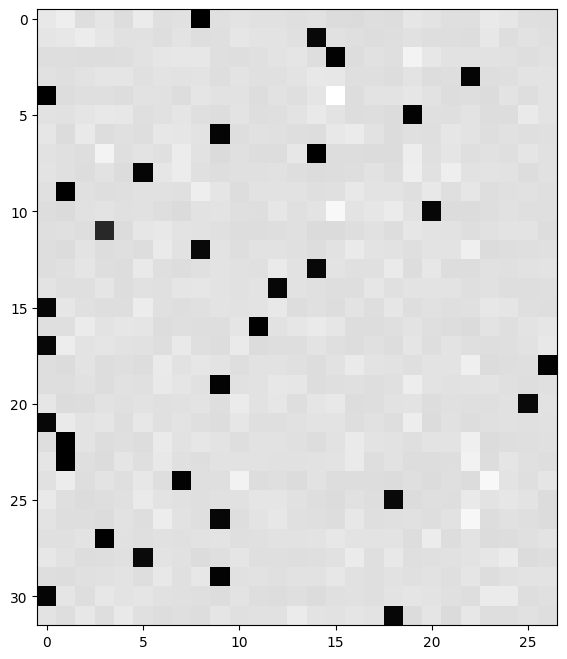

In [27]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(), cmap='gray')

In [31]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challange look at the mathematical expression of the output of batchnorm,
# take the derviative w.r.t. its input, simplify the expression, and just write it out

# Forward Pass:

# BEFORE:
# bnmeani = 1/n * hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff ** 2
# bnvar = 1 / (n-1) * (bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5) ** -0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# NOW:
hpreact_fast = bngain* (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())



max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [32]:
# Backward Pass

# BEFORE WE HAD:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
# dbndiff2 = (1.0 / (n-1)) * torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2 * bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0 / n * (torch.ones_like(hprebn) * dbnmeani)

# Calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain * bnvar_inv / n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact * bnraw).sum(0))


cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 6.984919309616089e-10


In [33]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

## Exercise 4: Putting it all together!

* We will train the MLP NN with our own backward pass!

In [39]:
# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the numbe of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((vocab_size, n_embd),             generator=g)

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1

# BatchNorm parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters on total
for p in parameters:
  p.requires_grad = True

# Same optimization
max_steps = 200000
batch_size = 32
n = batch_size # for convenience
lossi = []

# We will use this context manger for efficiency once our backward pass in written
with torch.no_grad():

  # kick off optimization:
  for i in range(max_steps):

    # MiniBatch Construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # Forward Pass:
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors

    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation

    # BatchNorm layer
    # ------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # ------------------------------------------------------

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass
    for p in parameters:
      p.grad = None
    # loss.backward() # use this for comparisons, delete later!

    #MANUAL BACKPROP!
    # ------------------------------------------------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n

    # 2nd layer of backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)

    # tanh
    dhpreact = (1.0 - h**2) * dh

    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain * bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)

    # Embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)

    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # ------------------------------------------------------

    # Update
    lr = 0.1 if i < 100000 else 0.01 # step lr decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # easy way
      p.data += -lr * grad # tough way

    # Track stats
    if i % 1000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


  # if i >= 100: # delete early breaking when we're ready to train the full NN
  #   break








12297
      0/ 200000: 3.7919
   1000/ 200000: 2.2335
   2000/ 200000: 2.3303
   3000/ 200000: 2.1954
   4000/ 200000: 2.2340
   5000/ 200000: 2.2879
   6000/ 200000: 2.1164
   7000/ 200000: 2.4705
   8000/ 200000: 2.0275
   9000/ 200000: 2.2283
  10000/ 200000: 2.1860
  11000/ 200000: 1.8704
  12000/ 200000: 2.2512
  13000/ 200000: 2.2136
  14000/ 200000: 2.6538
  15000/ 200000: 2.1186
  16000/ 200000: 2.5099
  17000/ 200000: 2.2530
  18000/ 200000: 2.0207
  19000/ 200000: 2.4611
  20000/ 200000: 2.3882
  21000/ 200000: 2.5256
  22000/ 200000: 1.8965
  23000/ 200000: 2.0199
  24000/ 200000: 2.5957
  25000/ 200000: 2.3047
  26000/ 200000: 2.3019
  27000/ 200000: 2.3730
  28000/ 200000: 2.0657
  29000/ 200000: 2.7245
  30000/ 200000: 2.4796
  31000/ 200000: 2.2399
  32000/ 200000: 2.3801
  33000/ 200000: 2.2949
  34000/ 200000: 1.9278
  35000/ 200000: 2.2171
  36000/ 200000: 2.1798
  37000/ 200000: 2.0417
  38000/ 200000: 2.5814
  39000/ 200000: 2.1010
  40000/ 200000: 1.9901
  41000/ 2

In [40]:
# useful for checking your gradients
# for p, g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [41]:
# Calibrate the batch norm at the end of training????????

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1

  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [43]:
# Evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val':   (Xdev, Ydev),
      'test':  (Xte, Yte),
  }[split]

  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.071544885635376
val 2.1083245277404785


In [44]:
# I achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [46]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # --------
    # Forward pass:

    # Embedding
    emb = C[torch.tensor([context])] # (1, block_size, d)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    #----------

    # Sample
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break


  print(''.join(itos[i] for i in out))

mora.
mayanniee.
mad.
ryla.
reisa.
jendraegelie.
kaielin.
shi.
jen.
eden.
sananaraelyn.
malaia.
noshub.
roshirael.
kindreelynn.
novana.
ubrence.
ryyah.
fael.
yuma.
